# Spectral methods in Julia

## David P. Sanders

Adapted from the notebook ["Benchmarking Julia on a PDE: the Kuramoto-Sivashinksy equation"](https://github.com/johnfgibson/julia-pde-benchmark/blob/master/1-Kuramoto-Sivashinksy-benchmark.ipynb) by John F. Gibson, Department of Mathematics and Statistics, University of New Hampshire

## The Kuramoto&ndash;Sivashinsky (KS) equation

The Kuramoto&ndash;Sivashinsky (KS) equation is a nonlinear partial differential equation (PDE) modelling the time evolution of a concentration $u(t, x)$ on a 1D spatial domain, given by

\begin{equation*}
u_t = -u u_{x} - u_{xx} - u_{xxxx},
\end{equation*}


where $x$ is space, $t$ is time, and subscripts indicate differentiation. We will take a spatial domain $x \in [0, L_x]$ with **periodic** boundary conditions.

### Numerical method: CNAB2 algorithm

The CNAB2 algorithm is a **spectral** numerical integration scheme for the KS equation.

It uses Fourier expansion in space, a collocation calculation of the nonlinear term $u u_x$, and finite-differencing in time, specifically 2nd-order Crank-Nicolson Adams-Bashforth (CNAB2) timestepping.

We take the initial condition $u(x, 0) = u_0(x)$. 

We will use a finite Fourier expansion to discretize space and finite-differencing to discretize time, specifically the 2nd-order rank-Nicolson/Adams-Bashforth (CNAB2) timestepping formula. CNAB2 is low-order but straightforward to describe and easy to implement for this simple benchmark.

Write the KS equation as 

$\newcommand{\LL}{\mathcal{L}}$
$\renewcommand{\NN}{\mathcal{N}}$

\begin{equation*}
u_t = \LL u + \NN(u),
\end{equation*}

where $\LL u := - u_{xx} - u_{xxxx}$ contains the linear terms 
and $\NN(u) := -u u_{x}$ corresponds to the nonlinear term. In practice we will use the equivalent form $\NN(u) = - \frac{1}{2} \frac{d}{dx}  u^2$. 

#### Time discretization

Discretize time by letting $u^n(x) := u(x, n\Delta t)$ for some small $\Delta t$. The CNAB2 time-stepping formula approximates  $u_t = \LL u + \NN(u)$ at time $t = n+ \frac{1}{2} dt$ as 

\begin{equation*}
\frac{u^{n+1} - u^n}{\Delta t} = \textstyle \frac{1}{2} \LL\left(u^{n+1} + u^n\right) + \frac{3}{2} \NN(u^n) - \frac{1}{2} \NN(u^{n-1})
\end{equation*}

Put the unknown future $u^{n+1}$'s on the left-hand side of the equation and the present $u^{n}$ and past $u^{n+1}$ on the right:

\begin{equation*}
\textstyle
\left(I  - \frac{\Delta t}{2} \LL \right) u^{n+1} = \left(I  + \frac{\Delta t}{2} \LL \right) u^{n} + \frac{3 \Delta t}{2} \NN(u^n) - \frac{\Delta t}{2} \NN(u^{n-1}).
\end{equation*}

Note that the linear operator $\LL$ applies to the unknown $u^{n+1}$ on the LHS, but that the nonlinear operator $\NN$ applies only to the knowns $u^n$ and $u^{n-1}$ on the RHS. This is an *implicit* treatment of the linear terms, which keeps the algorithm stable for large time steps, and an *explicit* treament of the nonlinear term, which makes the time-stepping equation linear in the unknown $u^{n+1}$.

#### Space discretization 

Now we discretize space with a finite Fourier expansion, so that $\hat{u}$ represents a vector of Fourier coefficients of $u$. Thus $\LL$ becomes a matrix &ndash; in fact, a diagonal matrix, since Fourier modes are eigenfunctions of the linear operator. 


Define $A := (I - \frac{\Delta t}{2} \LL)$, and $B := I + \frac{\Delta t}{2} \LL$, and let the vector $N^n$ be the Fourier transform of a collocation calculation of $\NN(u^n)$. That is, $N^n$ is the Fourier transform of $- u u_x = - \frac{1}{2} \frac{d}{dx} u^2$ calculated at $N_x$ uniformly-spaced grid points on the domain $[0, L_x]$. 

With the spatial discretization, the CNAB2 time-stepping formula becomes 

\begin{equation*}
\textstyle
A \, \hat{u}^{n+1} = B \, \hat{u}^n + \frac{3 \Delta t}{2} N^n -  \frac{\Delta t}{2}N^{n-1}
\end{equation*}

This is a simple $Ax=b$ linear algebra problem whose iteration approximates the time-evolution of the Kuramoto&ndash;Sivashinksy PDE. 

## Julia implementation of the CNAB2 algorithm


### Original version: MATLAB translation by John F. Gibson

In [1]:
using FFTW 

function ksintegrateNaive(u, Lx, dt, Nt, nsave)
    
    Nx = length(u)                  # number of gridpoints
    x = collect(0:(Nx-1)/Nx)*Lx
    kx = vcat(0:Nx/2-1, 0, -Nx/2+1:-1)  # integer wavenumbers: exp(2*pi*kx*x/L)
    alpha = 2*pi*kx/Lx              # real wavenumbers:    exp(alpha*x)
    D = 1im*alpha;                  # D = d/dx operator in Fourier space
    L = alpha.^2 - alpha.^4         # linear operator -D^2 - D^4 in Fourier space
    G = -0.5*D                      # -1/2 D operator in Fourier space
    
    Nsave = div(Nt, nsave)+1        # number of saved time steps, including t=0
    t = (0:Nsave)*(dt*nsave)        # t timesteps
    U = zeros(Nsave, Nx)            # matrix of u(xⱼ, tᵢ) values
    U[1,:] = u                      # assign initial condition to U
    s = 2                           # counter for saved data
    
    # Express PDE as u_t = Lu + N(u), L is linear part, N nonlinear part.
    # Then Crank-Nicolson Adams-Bashforth discretization is 
    # 
    # (I - dt/2 L) u^{n+1} = (I + dt/2 L) u^n + 3dt/2 N^n - dt/2 N^{n-1}
    #
    # let A = (I - dt/2 L) 
    #     B = (I + dt/2 L), then the CNAB timestep formula is
    # 
    # u^{n+1} = A^{-1} (B u^n + 3dt/2 N^n - dt/2 N^{n-1}) 

    # convenience variables
    dt2  = dt/2
    dt32 = 3*dt/2;
    A_inv = (ones(Nx) - dt2*L).^(-1)
    B     =  ones(Nx) + dt2*L

    Nn  = G.*fft(u.*u) # -u u_x (spectral), notation Nn = N^n     = N(u(n dt))
    Nn1 = copy(Nn)     #                   notation Nn1 = N^{n-1} = N(u((n-1) dt))
    u  = fft(u)        # transform u to spectral

    # timestepping loop
    for n = 1:Nt
        Nn1 = copy(Nn)                 # shift nonlinear term in time: N^{n-1} <- N^n
        Nn  = G.*fft(real(ifft(u)).^2) # compute Nn = -u u_x

        u = A_inv .* (B .* u + dt32*Nn - dt2*Nn1)
        
        if mod(n, nsave) == 0
            U[s,:] = real(ifft(u))
            s += 1            
        end
    end

    t,U
end

ksintegrateNaive (generic function with 1 method)

### Run the Julia code and plot results

In [2]:
using Plots

In [3]:
Lx = 64*pi
Nx = 1024
dt = 1/16
nsave = 8
Nt = 3200

x = Lx*(0:Nx-1)/Nx
u = cos.(x) + 0.1*sin.(x/8) + 0.01*cos.((2*pi/Lx)*x);
t, U = ksintegrateNaive(u, Lx, dt, Nt, nsave)

(0.0:0.5:200.5, [1.01 0.9932392150083477 … 0.9289720120969283 0.9883309693037653; 0.9970411098541802 0.9976108794748804 … 0.8874498370376636 0.9593001817559852; … ; 1.1592495343974547 1.2233963473381932 … 0.9808892271644796 1.0764158228247018; 1.1899395487945628 1.2606009763107742 … 1.0008359230482031 1.1012145528714077])

In [4]:
length(t)

402

In [5]:
size(U)

(401, 1024)

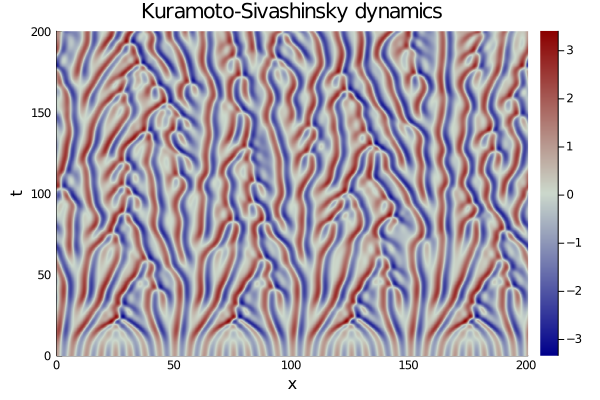

In [6]:
heatmap(x, t[1:size(U, 1)], U, xlim=(x[1], x[end]), ylim=(t[1], t[end]), fillcolor=:bluesreds)
plot!(xlabel="x", ylabel="t", title="Kuramoto-Sivashinsky dynamics")

In [7]:
using LinearAlgebra

$u_{xx}$ -- when we Fourier transform

$F(u_{xx})_k = -k^2 \hat{u}_k$

## Version with more Julia features

In [8]:
function KS_integrate(u, Lx, dt, Nt, nsave)
    
    Nx = length(u)                  # number of gridpoints
    x = [j * (Lx / Nx) for j in 0:Nx-1]
    kx = [0:(Nx/2 - 1); 0; (-Nx/2 + 1):-1]  # integer wavenumbers: exp(2*pi*kx*x/L)
    α = (2π / Lx) .* kx              # real wavenumbers:    exp(alpha*x)
    
    D = Diagonal(im .* α);                  # D = d/dx operator in Fourier space
    L = -D^2 - D^4              # linear operator -D^2 - D^4 in Fourier space
    G = -0.5 * D                      # -1/2 D operator in Fourier space
    
    Nsave = div(Nt, nsave)+1        # number of saved time steps, including t=0
    t = (0:Nsave)*(dt*nsave)        # t timesteps
    
    U = zeros(Nsave, Nx)            # matrix of u(xⱼ, tᵢ) values
    U[1, :] = u                      # assign initial condition to U
    s = 2                           # counter for saved data
    
    # Express PDE as u_t = Lu + N(u), L is linear part, N nonlinear part.
    # Then Crank-Nicolson Adams-Bashforth discretization is 
    # 
    # (I - dt/2 L) u^{n+1} = (I + dt/2 L) u^n + 3dt/2 N^n - dt/2 N^{n-1}
    #
    # let A = (I - dt/2 L) 
    #     B = (I + dt/2 L), then the CNAB timestep formula is
    # 
    # u^{n+1} = A^{-1} (B u^n + 3dt/2 N^n - dt/2 N^{n-1}) 

    # convenience variables
    
    A = I - (dt/2) * L
    B = I + (dt/2) * L

    Nn  = G * fft(u .* u) # -u u_x (spectral), notation Nn = N^n     = N(u(n dt))
    Nn1 = copy(Nn)     #                   notation Nn1 = N^{n-1} = N(u((n-1) dt))
    û  = fft(u)        # transform u to spectral

    # timestepping loop
    for n = 1:Nt
        Nn1 = copy(Nn)                 # shift nonlinear term in time: N^{n-1} <- N^n
        Nn  = G * fft(real(ifft(û)).^2) # compute Nn = -u u_x

        û = A \ (B * û + (dt/2)*(3*Nn - Nn1))
        
        if mod(n, nsave) == 0
            U[s, :] = real(ifft(û))
            s += 1            
        end
    end

    return t, U
end

KS_integrate (generic function with 1 method)

In [9]:
Lx = 64*pi
Nx = 1024
dt = 1/16
nsave = 8
Nt = 3200

x = Lx*(0:Nx-1)/Nx
u = cos.(x) + 0.1*sin.(x/8) + 0.01*cos.((2*pi/Lx)*x);
@time t, U = KS_integrate(u, Lx, dt, Nt, nsave)

  0.944009 seconds (1.98 M allocations: 715.729 MiB, 10.15% gc time)


(0.0:0.5:200.5, [1.01 0.9932392150083477 … 0.9289720120969283 0.9883309693037653; 0.9970411098541803 0.9976108794748805 … 0.8874498370376637 0.9593001817559854; … ; 1.1592496805529198 1.2233964718328285 … 0.9808894059827016 1.0764159871731513; 1.1899397191648449 1.2606011294363135 … 1.0008361173721918 1.1012147370209049])

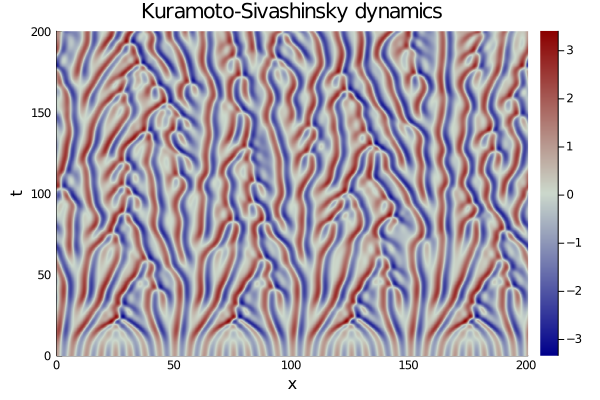

In [10]:
heatmap(x, t[1:size(U, 1)], U, xlim=(x[1], x[end]), ylim=(t[1], t[end]), fillcolor=:bluesreds)
plot!(xlabel="x", ylabel="t", title="Kuramoto-Sivashinsky dynamics")

## Version allowing us to modify the equation to be solved

Split the nonlinear part into two parts: a function $N_1$ applied pointwise to $u$,
and a spatial derivative operator $N_2$ applied to the result.

For example, to express $-0.5 u u_x = -0.5 (d/dx)(u^2)$, we put $N_1(x) = u^2$ and $N2(D) = -0.5 * D$, where $D$ is the differential operator.

In [11]:
using LinearAlgebra, FFTW

"""
Integrate a 1D time evolution PDE
``u_t = Lu + N(u)``
on a periodic domain.
where ``L(D)`` is the linear part as a function of the derivative
operator ``D``, expressed in terms of the derivative operator ``D``,
and ``N1`` and ``N2`` give the nonlinear part.
"""
function integrate_1D_evolution_PDE(u₀, L, N1, N2, Lx, dt, Nt, nsave)
    
    Nx = length(u₀)                  # number of grid points
    x = [j * (Lx / Nx) for j in 0:Nx-1]  # grid points
    kx = [0:(Nx/2 - 1); 0; (-Nx/2 + 1):-1]  # integer wavenumbers: exp(2π*kx*x/L)
    α = (2π / Lx) .* kx              # real wavenumbers:    exp(alpha*x)
    
    D = Diagonal(im .* α);      # D = d/dx operator in Fourier space multiplies by wavenumber
    LL = L(D)                   # linear operator in Fourier space
    
    Nsave = div(Nt, nsave)+1        # number of saved time steps, including t=0
    t = (0:Nsave)*(dt*nsave)        # t timesteps
    
    U = zeros(Nsave, Nx)            # matrix of u(xⱼ, tᵢ) values
    U[1, :] = u₀                      # assign initial condition to U
    s = 2                           # counter for saved data
    
    G = N2(D)  # differential operator for nonlinear part
    
    # convenience variables:
    A = I - (dt/2) * LL
    B = I + (dt/2) * LL

    Nn  = G * fft(N1.(u₀)) # N(u) (spectral), notation Nn = N^n     = N(u(n dt))
    Nn1 = copy(Nn)     #                   notation Nn1 = N^{n-1} = N(u((n-1) dt))
    û  = fft(u₀)        # transform u to spectral

    # time-stepping loop
    for n = 1:Nt
        Nn1 = copy(Nn)                 # shift nonlinear term in time: N^{n-1} <- N^n

        u = real(ifft(û))
        nonlin = N1.(u)
        Nn  = G * fft(nonlin)
        
        û = A \ (B * û + (dt/2)*(3*Nn - Nn1))  # CNAB2
        
        if mod(n, nsave) == 0
            U[s, :] = real(ifft(û))
            s += 1            
        end
    end

    return t, U
end

integrate_1D_evolution_PDE

KS equation again:

In [12]:
N1(u) = u^2
N2(D) = -0.5*D

L(D) = -D^2 - D^4

L (generic function with 1 method)

  1.227537 seconds (2.54 M allocations: 755.315 MiB, 10.55% gc time)


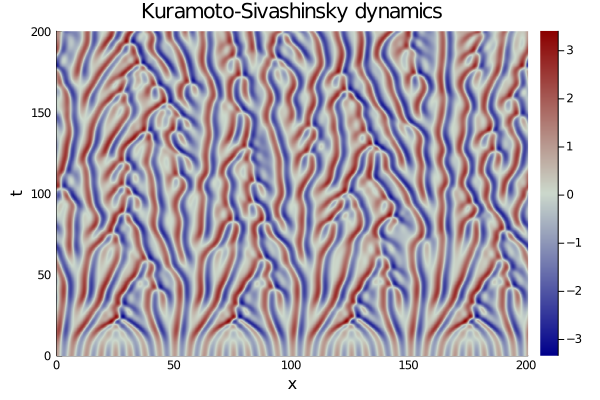

In [13]:
Lx = 64*pi
Nx = 1024
dt = 1/16
nsave = 8
Nt = 3200

x = Lx*(0:Nx-1)/Nx
u0 = cos.(x) + 0.1*sin.(x/8) + 0.01*cos.((2*pi/Lx)*x);

@time t, U = integrate_1D_evolution_PDE(u0, L, N1, N2, Lx, dt, Nt, nsave)

using Plots

heatmap(x, t[1:size(U, 1)], U, xlim=(x[1], x[end]), ylim=(t[1], t[end]), fillcolor=:bluesreds)
plot!(xlabel="x", ylabel="t", title="Kuramoto-Sivashinsky dynamics")

## Fisher--Kolmogorov PDE

$u_t = u_{xx} + u(1 - u)$

In [14]:
N1(u) = u * (1-u)
N2(D) = I  # no derivative in nonlinear term, so just use the identity

L(D) = D^2

L (generic function with 1 method)

In [15]:
Lx = 64*pi
Nx = 1024
dt = 0.001
nsave = 20
Nt = 20000

x = Lx*(0:Nx-1)/Nx
u0 = zeros(Nx)
u0[1] = 1

@time t, U = integrate_1D_evolution_PDE(u0, L, N1, N2, Lx, dt, Nt, nsave)

  2.933131 seconds (3.08 M allocations: 3.872 GiB, 18.00% gc time)


(0.0:0.02:20.02, [1.0 0.0 … 0.0 0.0; 0.395695216042071 0.24419184430122934 … 0.058348902448513096 0.24419184430122934; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN])

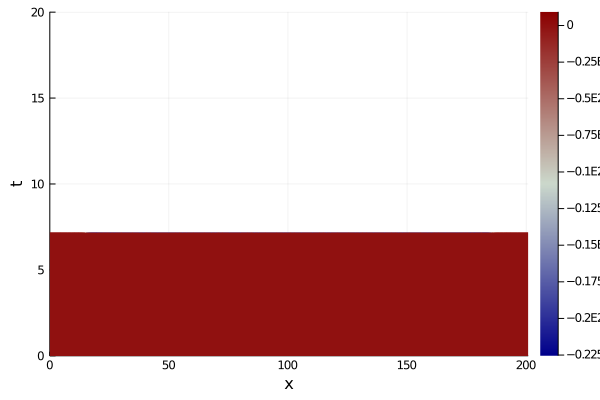

In [16]:
n = 1000
heatmap(x, t[1:n], U[1:n, :], xlim=(x[1], x[end]), ylim=(t[1], t[end]), fillcolor=:bluesreds)
plot!(xlabel="x", ylabel="t")

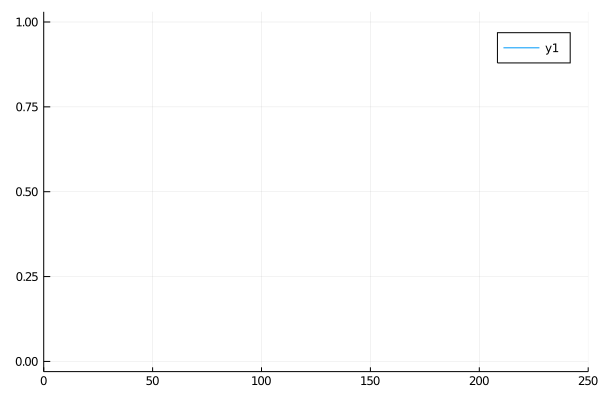

In [17]:
plot(U[400, :], xlim=(0, 250))

In [18]:
U[400, :]

1024-element Array{Float64,1}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

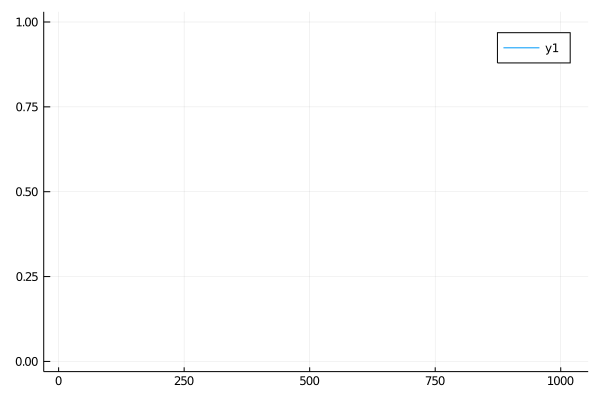

In [19]:
plot(U[400, :])